# Training a CNN on AutoArborist Data for Tree Genera Classification using PyTorch
# January 2024


In [ ]:
# Imports for Pytorch
import torch # version 2.1.2
import torchvision # version 0.16.2
#from torchvision import transforms # https://pytorch.org/vision/stable/transforms.html # To do: implement Pytorch transforms v2 (faster, more functionality)
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import v2

# Image Libraries
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# General Imports
import os
import shutil
import random
import numpy as np
from tqdm import tqdm



In [ ]:

# Set the paths for training and testing data
source_root = r"C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\auto_arborist_jpegs\jpegs_streetlevel_genus_idx_label"
training_destination_root = r"C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\pytorch_cnn_classifier\datasets\training_dataset_small_jan524"
testing_destination_root = r"C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\pytorch_cnn_classifier\datasets\testing_dataset_small_jan524"


In [ ]:
# Create a directory of images with folders named for each class, using the PyTorch ImageFolder Class: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html
# Each directory should contain a set of images labelled to genus

# Number of images to copy for training and testing
num_training_images_to_copy = 1000
num_testing_images_to_copy = 100

# Dictionary to keep track of selected training images for each genus
selected_training_images = {}

selected_genera = ['acer' 'fraxinus', 'quercus', 'ulmus', 'prunus', 'tilia', 'gleditsia', 'malus', 'platanus', 'liquidambar', 'pinus', 'ginkgo',
                  'zelkova', 'celtis', 'crataegus', 'populus', 'carpinus', 'syringa', 'lagerstroemia', 'betula']

# Iterate through the source directory
for genus_folder in os.listdir(source_root):
    genus_path = os.path.join(source_root, genus_folder)
    
    # Check if it's a directory and if it's in the selected genera list
    if os.path.isdir(genus_path) and genus_folder in selected_genera:
        # Create destination folders for the current genus
        training_destination_genus_path = os.path.join(training_destination_root, genus_folder)
        testing_destination_genus_path = os.path.join(testing_destination_root, genus_folder)
        os.makedirs(training_destination_genus_path, exist_ok=True)
        os.makedirs(testing_destination_genus_path, exist_ok=True)
        
        # List all images in the current genus folder
        images = [image for image in os.listdir(os.path.join(genus_path, 'images')) if image.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Randomly select num_training_images_to_copy images for training
        selected_training_images[genus_folder] = random.sample(images, min(num_training_images_to_copy, len(images)))
        
        # Copy selected training images to the training destination folder
        for image in selected_training_images[genus_folder]:
            source_image_path = os.path.join(genus_path, 'images', image)
            destination_image_path = os.path.join(training_destination_genus_path, image)
            shutil.copy2(source_image_path, destination_image_path)
        
        # Select num_testing_images_to_copy images for testing
        selected_testing_images = random.sample(images, min(num_testing_images_to_copy, len(images)))
        
        # Copy selected testing images to the testing destination folder
        for image in selected_testing_images:
            source_image_path = os.path.join(genus_path, 'images', image)
            destination_image_path = os.path.join(testing_destination_genus_path, image)
            shutil.copy2(source_image_path, destination_image_path)

print("Images copied successfully.")


In [4]:
# How many images are contained in the training and testing directories?

def print_directory_info(root_directory):
    for genus_folder in os.listdir(root_directory):
        genus_path = os.path.join(root_directory, genus_folder)
        
        # Check if it's a directory
        if os.path.isdir(genus_path):
            # Count the number of files in the directory
            num_files = len([f for f in os.listdir(genus_path) if os.path.isfile(os.path.join(genus_path, f))])
            
            print(f"Directory: {genus_folder}, Number of Files: {num_files}")

# Print information for the training directory
print("Training Directory Information:")
print_directory_info(training_destination_root)

# Print information for the testing directory
print("\nTesting Directory Information:")
print_directory_info(testing_destination_root)


Training Directory Information:
Directory: betula, Number of Files: 1000
Directory: carpinus, Number of Files: 1000
Directory: celtis, Number of Files: 1000
Directory: crataegus, Number of Files: 1000
Directory: ginkgo, Number of Files: 1000
Directory: gleditsia, Number of Files: 1000
Directory: lagerstroemia, Number of Files: 1000
Directory: liquidambar, Number of Files: 1000
Directory: malus, Number of Files: 1000
Directory: pinus, Number of Files: 1000
Directory: platanus, Number of Files: 1000
Directory: populus, Number of Files: 1000
Directory: prunus, Number of Files: 1000
Directory: quercus, Number of Files: 1000
Directory: syringa, Number of Files: 1000
Directory: tilia, Number of Files: 1000
Directory: ulmus, Number of Files: 1000
Directory: zelkova, Number of Files: 1000

Testing Directory Information:
Directory: betula, Number of Files: 100
Directory: carpinus, Number of Files: 100
Directory: celtis, Number of Files: 100
Directory: crataegus, Number of Files: 100
Directory: 

In [5]:

# Use Pytorch ImageFolder class to prepare training and testing datasets
train_data_dir = training_destination_root
test_data_dir = testing_destination_root

# Load the training and testing datasets as Pytorch Dataset Classes: https://pytorch.org/docs/stable/data.html
# The Pytorch torchvision.transforms module provides preprocessing functions: https://pytorch.org/vision/stable/transforms.html

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.CenterCrop(size=(512, 512)),
    v2.Resize(size=(512, 512), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.5860, 0.6267, 0.6007], std=[0.2441, 0.2345, 0.2840]), # per-band mean and std values for a given dataset
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

train_dataset = ImageFolder(train_data_dir, transform = train_transforms)
test_dataset = ImageFolder(test_data_dir, transform = test_transforms)

# Examine the train_dataset object
train_dataset

# Examine image dimensions: (3 channels, height 64, width 64)
img, label = train_dataset[0]
print(img.shape,label)


Dataset ImageFolder
    Number of datapoints: 18000
    Root location: C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\pytorch_cnn_classifier\datasets\training_dataset_small_jan524
    StandardTransform
Transform: Compose(
                 ToImage()
                 CenterCrop(size=(512, 512))
                 Resize(size=[512, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToDtype(scale=True)
           )

torch.Size([3, 512, 512]) 0


In [6]:
train_dataset.classes

['betula',
 'carpinus',
 'celtis',
 'crataegus',
 'ginkgo',
 'gleditsia',
 'lagerstroemia',
 'liquidambar',
 'malus',
 'pinus',
 'platanus',
 'populus',
 'prunus',
 'quercus',
 'syringa',
 'tilia',
 'ulmus',
 'zelkova']

In [7]:
print("Classes in the Training Dataset : \n", len(train_dataset.classes))
print("Classes in the Testing Dataset : \n", len(test_dataset.classes))

Classes in the Training Dataset : 
 18
Classes in the Testing Dataset : 
 18


Label : betula


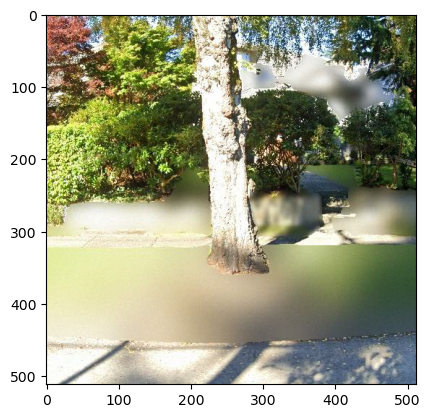

In [10]:
# Visualize sample image

def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0)) #reshape image from (3, H, W) to (H, W, 3)

#display the first image in the dataset
display_img(*train_dataset[3])



In [12]:
# Split training data into a validation set, and prepare dataset for training

# Define batch size for training 
bs = 32

# Define number of images for validation
val_size = 3000
train_size = len(train_dataset) - val_size

# Randomly split training data into train_data and val_data sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}") # Length of Train Data : 17212
print(f"Length of Validation Data : {len(val_data)}") # Length of Validation Data : 2000

# Use Pytorch DataLoader Class to iterate over a dataset for training: https://pytorch.org/docs/stable/data

train_dl = DataLoader(dataset = train_data, batch_size = bs, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(dataset = val_data, batch_size = bs*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(dataset = test_dataset, batch_size = 1, num_workers = 4, pin_memory = True)


Length of Train Data : 15000
Length of Validation Data : 3000


In [ ]:
# Visualize a single batch of images

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [13]:
# Prepare a Basic Model for Image Classification

import torch.nn as nn # contains base class for all neural network modules
import torch.nn.functional as F #https://pytorch.org/docs/stable/nn.functional.html contains common functions for training NNs (convolutions, losses, etc..)

class ImageClassificationBase(nn.Module): # https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
    # Define a base class with functionality for model training, validation, and evaluation per epoch
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
        

In [14]:
# Define a CNN Model using ResNet50
class ResNet101ImageClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Load the pre-trained ResNet model
        self.network = torchvision.models.resnet101(weights='ResNet101_Weights.IMAGENET1K_V2')
        # Modify the final fully connected layer to match the number of classes in your dataset
        num_classes = len(train_dataset.classes)
        in_features = self.network.fc.in_features
        self.network.fc = nn.Linear(in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [15]:
# Instantiate the model
model = ResNet101ImageClassification()

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\talake2/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth
100%|███████████████████████████████████████████████████████████████████████████████| 171M/171M [00:15<00:00, 11.7MB/s]


In [16]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

Number of Model Parameters:  42537042


In [ ]:
# Define a CNN Model using EfficientNetV2-S

class EfficientNetImageClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Load the pre-trained EfficientNetV2-L Model
        self.network = torchvision.models.efficientnet_v2_s(pretrained=True)
        # Modify the final fully connected layer to match the number of classes in your dataset
        num_classes = len(train_dataset.classes)
        in_features = self.network.classifier[1].in_features
        self.network.classifier = nn.Linear(in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)



In [ ]:
# Instantiate the model
model = EfficientNetImageClassification()


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of Model Parameters: ', params)

In [17]:
# Helper function and class to load data to GPU

def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)
    


In [ ]:
# Get GPU Device
device = get_default_device()
device

# Load data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

In [19]:

# Build custom loss function used in Autoarborist: Long-Tail Learning via Logit Adjustment (https://arxiv.org/pdf/2007.07314.pdf)
def build_loss_fn(use_la_loss, base_probs, tau=1.0):
    """Builds the loss function to be used for training.
    
    See: https://arxiv.org/pdf/2007.07314.pdf and as implemented in the AutoArborist paper.
    See: https://github.com/google-research/google-research/blob/master/logit_adjustment/main.py for source code.

    Args:
        use_la_loss (bool): Whether or not to use the logit-adjusted loss.
        base_probs (List[float]): Base probabilities to use in the logit-adjusted loss.
        tau (float): Temperature scaling parameter for the base probabilities.

    Returns:
        A loss function with signature loss(targets, logits).
    """
    
    base_probs_tensor = torch.tensor(base_probs, dtype=torch.float32)
    
    def loss_fn(targets, logits):
        if use_la_loss:
            logits = logits + torch.log(base_probs_tensor.pow(tau) + 1e-12)
        
        loss = F.cross_entropy(logits, targets)
        return loss

    return loss_fn


def calculate_base_probs(class_counts, smoothing_constant):
    total_counts = np.sum(class_counts)
    base_probs = [(count + smoothing_constant) / (total_counts + len(class_counts) * smoothing_constant) for count in class_counts]
    return base_probs



In [20]:

# Input class counts for each class to adjust loss weights based on dominant/rare classes
class_counts = [100, 100, 100]  # Replace with actual class counts from your training set
smoothing_constant = 1000  # You can adjust this value based on your experiments, Autoarborist used c = 1000

base_probs = calculate_base_probs(class_counts, smoothing_constant)
print(base_probs)

# Use the Logit Adjusted Cross Entropy Loss for Long-Tail Learning
use_la_loss = True  # Set to True to use logit-adjusted loss
base_probs = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
tau = 1.0 #tau parameter for logit adjustment: https://github.com/google-research/google-research/blob/master/logit_adjustment/main.py

# Build the loss function
loss_fn = build_loss_fn(use_la_loss, base_probs, tau)

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


In [21]:
# Define Fit and Evaluation methods

# Do not compute new gradients when evaluating a model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Fit model
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    # Create optimizer with initial learning rate
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        
        for batch in train_loader:
            # Forward pass: prediction & calculate loss
            loss = model.training_step(batch)
            train_losses.append(loss)
            # Backward pass: backpropagate loss & calculate gradients
            loss.backward()
            optimizer.step() #update gradients
            optimizer.zero_grad() #zero gradients for next training forward pass
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

# Following the Autoarborist paper, fit model with one epoch of linear warmup, 4 epochs at a 0.01 learning rate, and one epoch at 0.001.
def fit_with_warmup(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, warmup_epochs=1):
    
    history = []
    # Create optimizer with initial learning rate
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        
        # Linear warmup
        if epoch < warmup_epochs:
            lr_scale = (epoch + 1) / warmup_epochs
            lr_warmup = lr * lr_scale
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_warmup
        
        for batch in train_loader:
            # Forward pass: prediction & calculate loss
            loss = model.training_step(batch)
            train_losses.append(loss)
            # Backward pass: backpropagate loss & calculate gradients
            loss.backward()
            optimizer.step()  # update gradients
            optimizer.zero_grad()  # zero gradients for the next training forward pass
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history


# Following the Autoarborist paper, fit model with one epoch of linear warmup, 4 epochs at a 0.01 learning rate, and one epoch at 0.001.
# Handling the data imbalance. Autoarborist uses the logit adjustment method for training on imbalanced data proposed in Menon et al., 2021.
def fit_with_warmup_and_logit_adjustment(epochs, lr, model, train_loader, val_loader,
                                         opt_func=torch.optim.SGD, warmup_epochs=1,
                                         use_la_loss=False, base_probs=None, tau=1.0):
    history = []
    # Create optimizer with initial learning rate
    optimizer = opt_func(model.parameters(), lr)
    
    # Move base_probs to the same device as the model
    base_probs_tensor = torch.tensor(base_probs, dtype=torch.float32, device=next(model.parameters()).device)
    
    # Build the loss function
    loss_fn = build_loss_fn(use_la_loss, base_probs_tensor, tau)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        
        # Linear warmup
        if epoch < warmup_epochs:
            lr_scale = (epoch + 1) / warmup_epochs
            lr_warmup = lr * lr_scale
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_warmup
        
        for batch in train_loader:
            # Forward pass: prediction & calculate loss
            inputs, targets = batch  # Assuming each batch is a tuple (data, labels)
            logits = model(inputs)
            loss = loss_fn(targets, logits)

            train_losses.append(loss)

            # Backward pass: backpropagate loss & calculate gradients
            loss.backward()
            optimizer.step()  # update gradients
            optimizer.zero_grad()  # zero gradients for the next training forward pass

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history



In [22]:
#load the model to the device
model = to_device(ResNet101ImageClassification(), device)

In [23]:

# Set number of epochs, optimizer function, learning rate, and warmup epochs
num_epochs = 20
opt_func = torch.optim.Adam
base_lr = 0.01
warmup_epochs = 1


In [ ]:
# Fit model with warmup, logit adjustment, and record results after each epoch
#history = fit_with_warmup_and_logit_adjustment(num_epochs, base_lr, model, train_dl, val_dl,
#                                               opt_func, warmup_epochs,
#                                               use_la_loss=True, base_probs=base_probs, tau=1.0)

# Fit model with warmup and record results after each epoch
#history = fit_with_warmup(num_epochs, base_lr, model, train_dl, val_dl, opt_func, warmup_epochs)

# Fit model and record result after epoch
history = fit(num_epochs, base_lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 2.9088, val_loss: 2.8892, val_acc: 0.0648
Epoch [1], train_loss: 2.9005, val_loss: 2.8922, val_acc: 0.0754
Epoch [2], train_loss: 2.8824, val_loss: 2.8800, val_acc: 0.0764
Epoch [3], train_loss: 2.8802, val_loss: 3.0021, val_acc: 0.0553


In [ ]:
history

In [ ]:
# Save the model
model_path = r'C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\pytorch_cnn_classifier\models\tree-classification-experiments-21top-genera-1000imgs-resnet50-100epochs-lr001-jan524.pth'

# https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), model_path)

In [ ]:
# Load a pre-trained model
model_path = r'C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\pytorch_cnn_classifier\models\tree-classification-experiments-21top-genera-1000imgs-effnetv2s-10epochs-jan524.pth'

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
# Predict on a single image

from PIL import Image
import cv2

def predict_img_class(img,model):
    """ Predict the class of image"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return train_dataset.classes[preds[0].item()]

#open image file
img = cv2.imread(r"C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\pytorch_cnn_classifier\datasets\testing_dataset_small_jan524\picea\9a724fda-0d05-11ec-8069-e35304080eff.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

# Resize the image
img_rgb = cv2.resize(img_rgb, (512, 512))

#convert image to tensor
img_rgb = v2.ToTensor()(img_rgb)

#prdict image label
print(f"Predicted Class : {predict_img_class(img_rgb,model)}")

In [ ]:
# Model Evaluation with Confusion Matrix
# Iterate over test dataset and generate predictions for a confusion matirx

y_pred = []
y_true = []

for inputs, labels in test_dl:
    inputs, labels = inputs.cuda(), labels.cuda()
    output = model(inputs) # Feed Network
    # print(output) # tensor of predicted probabilities for output classes
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy() # softmax operation to select class with highest probability
    #print(f'Predicted Label:', output)
    y_pred.extend(output) # Save Predicted Label
    
    labels = labels.data.cpu().numpy()
    #print(f'True Label:', labels)
    y_true.extend(labels) # Save True Label
    


In [ ]:
# Calculate and plot confusion matrix with skikit-learn

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import numpy as np

# Constant for classes    
classes = ('acer', 'pinus', 'phoenix')

# Confusion Matirx
cf_matrix = confusion_matrix(y_true, y_pred)


In [ ]:
cf_matrix

In [ ]:
disp = ConfusionMatrixDisplay(cf_matrix, display_labels = classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation = 'vertical')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names = classes))



# Load a trained Image Classification Model (CNN)

In [28]:
# Imports for Pytorch
import torch # version 2.1.2
import torchvision # version 0.16.2
from torchvision import transforms # https://pytorch.org/vision/stable/transforms.html # To do: implement Pytorch transforms v2 (faster, more functionality)
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

# Image Libraries
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# General Imports
import os
import shutil
import random
import numpy as np
from tqdm import tqdm



In [ ]:
# Prepare a Basic Model for Image Classification

import torch.nn as nn # contains base class for all neural network modules
import torch.nn.functional as F #https://pytorch.org/docs/stable/nn.functional.html contains common functions for training NNs (convolutions, losses, etc..)

class ImageClassificationBase(nn.Module): # https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
    # Define a base class with functionality for model training, validation, and evaluation per epoch
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [35]:
# Define a CNN Model using EfficientNetV2-S

class EfficientNetImageClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Load the pre-trained EfficientNetV2-L Model
        self.network = torchvision.models.efficientnet_v2_s(pretrained=True)
        # Modify the final fully connected layer to match the number of classes in your dataset
        num_classes = 15
        in_features = self.network.classifier[1].in_features
        self.network.classifier = nn.Linear(in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)
    

In [ ]:
# Helper function and class to load data to GPU

def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)
    

In [ ]:
# Load a pre-trained model
model_path = r'C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\pytorch_cnn_classifier\models\tree-classification-experiments-15top-genera-1000imgs-effnetv2s-jan524.pth'

# Get GPU Device
device = get_default_device()
device

# Instantiate the model with the same architecture as the model which parameters you saved
model = EfficientNetImageClassification()

#load the model to the device
model = to_device(EfficientNetImageClassification(), device)

model.load_state_dict(torch.load(model_path))

model.eval() # Call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
 

# Classification on a Single Image

In [ ]:
# Constant for classes    
classes = ('acer', 'fraxinus', 'quercus', 'ulmus', 'prunus', 'tilia', 'pyrus', 'gleditsia', 'platanus', 'liquidambar', 'pinus', 'magnolia', 'picea', 'ginkgo', 'zelkova')

img_path = r'C:\Users\talake2\Desktop\auto_arborist_cvpr2022_v015\auto_arborist_jpegs\jpegs_aerial_streetlevel_raw\all_cities_streetview\train\acer\streetlevel_4_2.jpg'
img = imread(img_path)
img.shape

# Resize the image
img = cv2.resize(img, (512, 512))

# Convert image to tensor using torchvision.transforms.ToTensor()
transform = transforms.ToTensor()
img = transform(img) #Transforms image to [0-1] and channels first
img = img.unsqueeze(0) #add first dimension of batch size
img = img.cuda() #push to GPU

#prdict image label
output = model(img)

# Get the index of the maximum value in the output tensor
predicted_class_index = torch.argmax(output)

# Use the index to get the corresponding class label
predicted_class_label = classes[predicted_class_index.item()]

print("Predicted Class Label:", predicted_class_label)